In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv("housing.csv")
df.head()

,address,bed_bath,more_info,price,status,zip_code
0,"360 E Randolph St # 601-602, Chicago, IL","3 bds · 4 ba · 2,700 sqft",http://www.zillow.com/homedetails/360-E-Randol...,"$1,299,000",Condo For Sale,60601
1,"8 E Randolph St UNIT 1006, Chicago, IL",1 bd · 1 ba · 850 sqft,http://www.zillow.com/homedetails/8-E-Randolph...,"$324,900",Condo For Sale,60601
2,NaN,NaN,NaN,NaN,NaN,60601
3,"340 E Randolph St APT 704, Chicago, IL","2 bds · 3 ba · 1,902 sqft",http://www.zillow.com/homedetails/340-E-Randol...,"$1,099,000",Condo For Sale,60601
4,"420 E Waterside Dr UNIT 310, Chicago, IL","2 bds · 3 ba · 1,500 sqft",http://www.zillow.com/homedetails/420-E-Waters...,"$567,770",Condo For Sale,60601


### Data Cleaning

In [3]:
#drops rows with NaN values
df = df.dropna()
#gets rid of $ and ,, in the prices
df["price"] = df["price"].str.replace("$", "")
df["price"] = df["price"].str.replace(",", "")
df["price"] = df["price"].str.replace("M", "")
df["price"] = df["price"].str.replace("K", "")
df["price"] = df["price"].str.replace("+", "")
#change values to floats from strings
df["price"] = df["price"].apply(float)
#drop the 134 rows that have a funky format in bed_bath
#(found using the following code: df.loc[df["bed_bath"].str.contains("lot") == True].shape)
df = df.loc[df["bed_bath"].str.contains("lot") == False]

In [4]:
#turn "--" into 0 in bed_bath and turn "Studio" into "0 bds"
df["bed_bath"] = df["bed_bath"].str.replace("--", "0")
df["bed_bath"] = df["bed_bath"].str.replace("Studio", "0 bds")

In [5]:
#assigning the "bed_bath" splits to a new df (that I can join to the original df later)
df_bbsplit = pd.DataFrame(df["bed_bath"].str.split(" · ").tolist(), columns = ["beds", "baths", "sqft"])

In [6]:
#clean the data in the new df columns to change to ints
df_bbsplit["sqft"] = df_bbsplit["sqft"].str.replace(",",'')
df_bbsplit["sqft"] = df_bbsplit["sqft"].str.replace("sqft","")
df_bbsplit["sqft"] = df_bbsplit["sqft"].str.replace("+","")
df_bbsplit["beds"] = df_bbsplit["beds"].str.replace(" bds","")
df_bbsplit["beds"] = df_bbsplit["beds"].str.replace(" bd","")
df_bbsplit["baths"] = df_bbsplit["baths"].str.replace(" ba","")

In [7]:
#convert to ints
df_bbsplit["sqft"] = pd.to_numeric(df_bbsplit["sqft"])
df_bbsplit["beds"] = pd.to_numeric(df_bbsplit["beds"])
df_bbsplit["baths"] = pd.to_numeric(df_bbsplit["baths"])

In [8]:
#get dummies for status using the built-in n -1 thing.
df_status_dummies = pd.get_dummies(df["status"], drop_first=True)
df_status_dummies.head()

,Auction,Co-op For Sale,Coming Soon,Condo For Sale,For Sale by Owner,Foreclosure,House For Sale,Lot/Land For Sale,Make Me Move®,New Construction,Townhouse For Sale
0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0
5,0,0,0,1,0,0,0,0,0,0,0


In [18]:
#fix index problems
df_status_dummies.index = range(len(df_status_dummies))

In [9]:
#create operationalized target-- >= to median (273500.0) is high, < is low
df["is_high"] = df["price"].apply(lambda x: 1 if x >=273500.0 else 0)

In [10]:
#create target
target = df["is_high"]

In [11]:
#create version of original df with only relevant columns to join others to
df_zip = df[["zip_code"]]

In [19]:
#fix index to conform with bbsplit
df_zip.index = range(len(df_zip))

In [20]:
#join together 2 dfs
housing_data_intm = pd.merge(df_zip, df_bbsplit, how="inner", left_index=True, right_index=True)
housing_data_intm.head()

,zip_code,beds,baths,sqft
0,60601,3,4.0,2700
1,60601,1,1.0,850
2,60601,2,3.0,1902
3,60601,2,3.0,1500
4,60601,3,3.0,2367


In [21]:
#join together all three
housing_data = pd.merge(housing_data_intm, df_status_dummies, how="inner", left_index=True, right_index=True)

In [22]:
housing_data.head()

,zip_code,beds,baths,sqft,Auction,Co-op For Sale,Coming Soon,Condo For Sale,For Sale by Owner,Foreclosure,House For Sale,Lot/Land For Sale,Make Me Move®,New Construction,Townhouse For Sale
0,60601,3,4.0,2700,0,0,0,1,0,0,0,0,0,0,0
1,60601,1,1.0,850,0,0,0,1,0,0,0,0,0,0,0
2,60601,2,3.0,1902,0,0,0,1,0,0,0,0,0,0,0
3,60601,2,3.0,1500,0,0,0,1,0,0,0,0,0,0,0
4,60601,3,3.0,2367,0,0,0,1,0,0,0,0,0,0,0


In [23]:
housing_data.tail()

,zip_code,beds,baths,sqft,Auction,Co-op For Sale,Coming Soon,Condo For Sale,For Sale by Owner,Foreclosure,House For Sale,Lot/Land For Sale,Make Me Move®,New Construction,Townhouse For Sale
4787,60827,4,3.0,1775,0,0,0,0,0,0,1,0,0,0,0
4788,60827,4,2.0,910,0,0,0,0,0,0,1,0,0,0,0
4789,60827,8,3.0,0,0,0,0,0,0,0,0,0,0,0,0
4790,60827,3,1.0,1191,0,0,0,0,0,0,1,0,0,0,0
4791,60827,4,2.0,1181,0,0,0,0,0,0,1,0,0,0,0


In [24]:
housing_data.shape

(4792, 15)

In [25]:
#figure out correlations housing_data columns to each other
housing_data.corr()

,zip_code,beds,baths,sqft,Auction,Co-op For Sale,Coming Soon,Condo For Sale,For Sale by Owner,Foreclosure,House For Sale,Lot/Land For Sale,Make Me Move®,New Construction,Townhouse For Sale
zip_code,1.000000,0.058965,-0.037255,-0.030224,0.062181,0.003306,-0.008460,-0.203269,0.023430,0.054073,0.210167,-0.050823,0.003603,-0.059467,-0.032733
beds,0.058965,1.000000,0.646195,0.161726,-0.063344,-0.028461,0.010833,-0.423062,0.028267,0.069932,0.223920,-0.247060,0.000552,0.039780,-0.018527
baths,-0.037255,0.646195,1.000000,0.379226,-0.102652,-0.016667,0.022010,-0.192598,0.029790,-0.022302,0.177322,-0.261183,0.002496,0.151194,0.068768
sqft,-0.030224,0.161726,0.379226,1.000000,0.018277,-0.003525,0.015415,-0.061501,0.021523,-0.034160,0.170721,-0.132905,0.026041,0.124637,0.030845
Auction,0.062181,-0.063344,-0.102652,0.018277,1.000000,-0.013756,-0.009217,-0.175471,-0.039998,-0.043527,-0.132040,-0.034774,-0.025493,-0.037265,-0.032417
Co-op For Sale,0.003306,-0.028461,-0.016667,-0.003525,-0.013756,1.000000,-0.002808,-0.053463,-0.012187,-0.013262,-0.040231,-0.010595,-0.007767,-0.011354,-0.009877
Coming Soon,-0.008460,0.010833,0.022010,0.015415,-0.009217,-0.002808,1.000000,-0.035823,-0.008166,-0.008886,-0.026956,-0.007099,-0.005204,-0.007608,-0.006618
Condo For Sale,-0.203269,-0.423062,-0.192598,-0.061501,-0.175471,-0.053463,-0.035823,1.000000,-0.155459,-0.169175,-0.513193,-0.135153,-0.099081,-0.144837,-0.125992
For Sale by Owner,0.023430,0.028267,0.029790,0.021523,-0.039998,-0.012187,-0.008166,-0.155459,1.000000,-0.038563,-0.116981,-0.030808,-0.022585,-0.033015,-0.028719
Foreclosure,0.054073,0.069932,-0.022302,-0.034160,-0.043527,-0.013262,-0.008886,-0.169175,-0.038563,1.000000,-0.127303,-0.033526,-0.024578,-0.035928,-0.031253


In [39]:
#figure out correlations between target and housing_data
target_merge = target.to_frame()
target_merge.index = range(len(target_merge))
full_data = pd.merge(housing_data, target_merge, how="inner", left_index=True, right_index=True)

In [40]:
full_data.head()

,zip_code,beds,baths,sqft,Auction,Co-op For Sale,Coming Soon,Condo For Sale,For Sale by Owner,Foreclosure,House For Sale,Lot/Land For Sale,Make Me Move®,New Construction,Townhouse For Sale,is_high
0,60601,3,4.0,2700,0,0,0,1,0,0,0,0,0,0,0,1
1,60601,1,1.0,850,0,0,0,1,0,0,0,0,0,0,0,1
2,60601,2,3.0,1902,0,0,0,1,0,0,0,0,0,0,0,1
3,60601,2,3.0,1500,0,0,0,1,0,0,0,0,0,0,0,1
4,60601,3,3.0,2367,0,0,0,1,0,0,0,0,0,0,0,1


In [41]:
full_data.shape

(4792, 16)

In [42]:
#Anna note to self: is there a way to do this without having to make a df with the target added?
full_data.corr()["is_high"]

zip_code             -0.163766
beds                  0.071893
baths                 0.391767
sqft                  0.238391
Auction              -0.216417
Co-op For Sale       -0.014139
Coming Soon           0.032948
Condo For Sale        0.177402
For Sale by Owner    -0.017234
Foreclosure          -0.181051
House For Sale       -0.013742
Lot/Land For Sale    -0.132645
Make Me Move®         0.064854
New Construction      0.169738
Townhouse For Sale    0.082592
is_high               1.000000
Name: is_high, dtype: float64

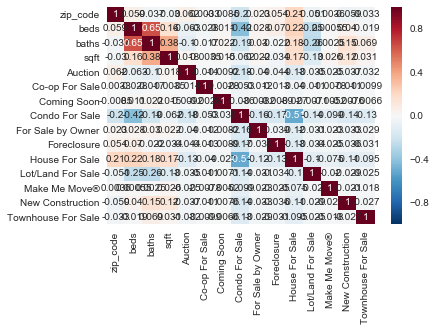

In [43]:
#do the seaborn heat map thing
sns.heatmap(housing_data.corr(), annot=True)